In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pymc3 as pm
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
from numpy.random import multivariate_normal as mvn

# Introduction

GPs are distributions, not over variables, like the Normal distribution over a random variable $X$, but over functions. There are three excellent, free resources, for learning GPs (in increasing length and breadth of coverage)
1. A 30 page introduction by David MacKay https://www.ics.uci.edu/~welling/teaching/KernelsICS273B/gpB.pdf
2. David Duvenand's thesis: https://www.cs.toronto.edu/~duvenaud/thesis.pdf
2. Gaussian Processes for Machine Learning: http://www.gaussianprocess.org/

I shall assume you're familiar with the idea of GPs and just focus on the specific implementations and interpretations. 

# Multivariate normals

First we'll get acquainted with multivariate normals using Numpy, without the fancy machineary of PyMC3. 

Our function space will be always be defined on a unit interval, square, cube, hypercube etc. 

$$
f \sim \mathcal{N}(0, \sigma^{2}I)
$$

where I is the identity matrix

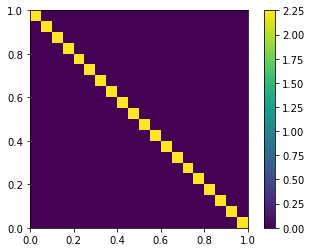

In [46]:
N = 20
I = np.eye(N)
sigma = 1.5


cov = I*sigma**2


fig, ax = plt.subplots()
c = ax.imshow(cov, extent=[0, 1, 0, 1])
plt.colorbar(c)



This covariance matrix says values of X which are different have no covariance (correlation), whereas the covariance of observations at the same values of $X$ have a variances of 2.25. 

Let's take 10 different draws from this MVN: 

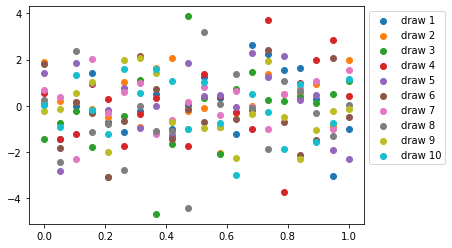

In [44]:
for i in range(10):
    f = mvn(np.zeros(N), cov)
    plt.scatter(X, f, label=f"draw {i+1}")
plt.legend(bbox_to_anchor=(1, 1))

Now let's change the covariance matrix to something a bit more interesting.  Let's define the elements according to the Gaussian function: 

$$
k_{i, j}  = \frac{1}{l\sqrt{2\pi}}\exp{\frac{-(x_{i}-x_{j})^2}{2l^2}}
$$

$$
l  = 0.5
$$



In [62]:
def gauss(x, y, l=0.5):
    k = 1/(l*np.sqrt(np.pi*2))
    k *= np.exp(-0.5*(x-y)**2/l**2)
    return k

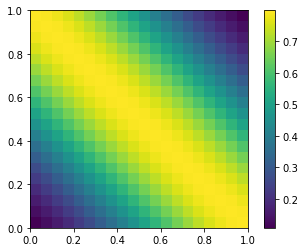

In [67]:
x = np.linspace(0, 1, N)[:, None]
X1, X2 = np.meshgrid(x, x)
cov = gauss(X1, X2)
c = plt.imshow(cov, extent=[0, 1, 0, 1])
plt.colorbar(c)

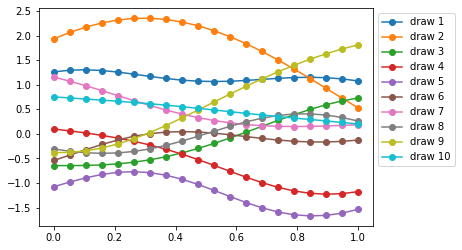

In [70]:
for i in range(10):
    f = mvn(np.zeros(N), cov)
    plt.plot(x, f, label=f"draw {i+1}", marker='o')
plt.legend(bbox_to_anchor=(1, 1))

We can change the value of l to something smaller

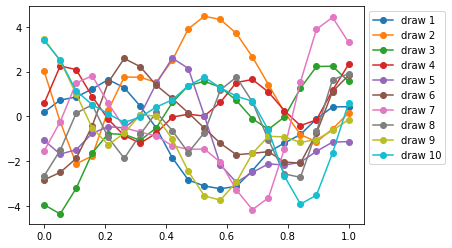

In [72]:
cov = gauss(X1, X2, l=0.1)
for i in range(10):
    f = mvn(np.zeros(N), cov)
    plt.plot(x, f, label=f"draw {i+1}", marker='o')
plt.legend(bbox_to_anchor=(1, 1))

or something really large

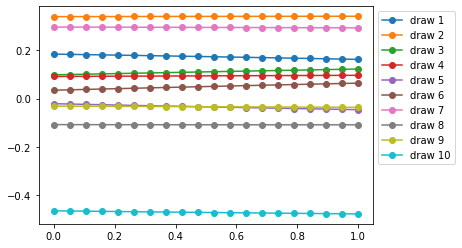

In [73]:
cov = gauss(X1, X2, l=10)
for i in range(10):
    f = mvn(np.zeros(N), cov)
    plt.plot(x, f, label=f"draw {i+1}", marker='o')
plt.legend(bbox_to_anchor=(1, 1))

All of this is implemented in PyMC3. Sample is just repeatedly drawing from the MVN

In [74]:
X = np.linspace(0, 1, 20)[:, None]

with pm.Model() as model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.5)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)
    
    trace = pm.sample(10)

INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_]
Sampling 2 chains: 100%|██████████| 1020/1020 [00:01<00:00, 951.70draws/s]
/Users/robertarbon/opt/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc3/sampling.py:466: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


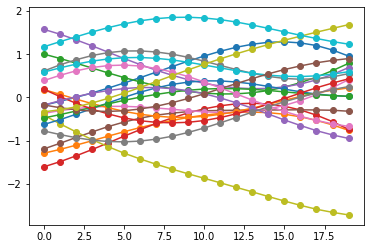

In [76]:
for i in range(trace.shape[0]):
_ = plt.plot(trace.f.T, marker='o')